In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random


In [2]:
def create_sequences(data, seq_length):
    """Create input sequences and target values"""
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, -1]  # Target is the CO2 value
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
    
    def forward(self, x):
        # Forward pass through LSTM
        lstm_out, _ = self.lstm(x)
        
        # Take the last time step output
        out = lstm_out[:, -1, :]
        
        # Apply dropout and fully connected layers
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out.squeeze()

In [4]:
def preprocess_data(df):
    # Add log-transformed CO2 as a feature
    df['log_co2'] = np.log1p(df['co2'])

    
    # Create a copy of the dataframe with the target variable as the last column
    features_df = df.drop(columns=['year', 'co2'])
    
    # Convert to numpy array - assuming data is already normalized
    data = features_df.values
    
    return data

In [5]:

def train_and_evaluate(X, y, df, input_size, sequence_length):
    # Define training and testing periods
    train_years = 160
    test_years = 14
    
    # Calculate the split point for the data
    total_years = len(df)
    test_indices = range(total_years - test_years, total_years)
    
    # For sequences, we need to adjust the split point to account for the sequence length
    test_start_idx = len(X) - test_years
    
    # Split data into train and test sets
    X_train = X[:test_start_idx]
    y_train = y[:test_start_idx]
    X_test = X[test_start_idx:]
    y_test = y[test_start_idx:]
    
    # Check dimensions
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    print(f"Training on first {train_years} years, testing on last {test_years} years")
    
    # Convert to PyTorch tensors
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
    
    # Initialize model
    model = LSTMModel(
        input_size=input_size,
        hidden_size=64,
        num_layers=2,
        dropout=0.2
    ).to(device)
    
    # Initialize training components
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Training loop
    epochs = 250
    train_losses = []
    best_loss = float('inf')
    best_model_state = None
    
    print(f"Training on {len(X_train_tensor)} samples")
    print(f"Testing on {len(X_test_tensor)} samples (last {test_years} years)")
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        train_out = model(X_train_tensor)
        train_loss = criterion(train_out, y_train_tensor)
        train_loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        # Store loss
        train_losses.append(train_loss.item())
        
        # Save best model
        if train_loss < best_loss:
            best_loss = train_loss.item()
            best_model_state = model.state_dict().copy()
        
        # Print progress
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss.item():.4f}")
    
    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test_tensor).cpu().numpy()
    
    test_actuals = y_test_tensor.cpu().numpy()
    
    # Get the years for the test set from the original dataframe
    test_years_values = df['year'].iloc[-test_years:].values
    
    return model, test_preds, test_actuals, test_years_values

In [6]:
def evaluate_and_visualize(model, test_preds, test_actuals, test_years_values):
    # Convert log predictions back to original scale
    log_actuals = test_actuals
    log_preds = test_preds
    
    # Original scale predictions
    actuals_co2 = np.expm1(log_actuals)
    preds_co2 = np.expm1(log_preds)
    
    # Calculate metrics
    log_mse = mean_squared_error(log_actuals, log_preds)
    log_mae = mean_absolute_error(log_actuals, log_preds)
    log_r2 = r2_score(log_actuals, log_preds)
    
    co2_mse = mean_squared_error(actuals_co2, preds_co2)
    co2_mae = mean_absolute_error(actuals_co2, preds_co2)
    co2_r2 = r2_score(actuals_co2, preds_co2)
    
    print("\n--- Test Set Evaluation ---")
    print(f"Log Scale - MSE: {log_mse:.4f}, MAE: {log_mae:.4f}, R²: {log_r2:.4f}")
    print(f"Original Scale - MSE: {co2_mse:.2f}, MAE: {co2_mae:.2f}, R²: {co2_r2:.4f}")
    
    # Visualization: Predicted vs Actual
    plt.figure(figsize=(12, 10))
    
    # Log scale plot
    plt.subplot(2, 1, 1)
    plt.plot(test_years_values, log_actuals, label='Actual log(CO₂)', marker='o')
    plt.plot(test_years_values, log_preds, label='Predicted log(CO₂)', marker='x')
    plt.title('Predicted vs Actual CO₂ Emissions (log scale)')
    plt.xlabel('Year')
    plt.ylabel('log(CO₂)')
    plt.legend()
    plt.grid(True)
    
    # Original scale plot
    plt.subplot(2, 1, 2)
    plt.plot(test_years_values, actuals_co2, label='Actual CO₂', marker='o')
    plt.plot(test_years_values, preds_co2, label='Predicted CO₂', marker='x')
    plt.title('Predicted vs Actual CO₂ Emissions (original scale)')
    plt.xlabel('Year')
    plt.ylabel('CO₂ Emissions')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Create a residual plot
    plt.figure(figsize=(12, 6))
    
    # Residuals over time
    plt.subplot(1, 2, 1)
    residuals = log_actuals - log_preds
    plt.scatter(test_years_values, residuals)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Residuals Over Time (log scale)')
    plt.xlabel('Year')
    plt.ylabel('Residual')
    plt.grid(True)
    
    # Residual distribution
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.title('Distribution of Residuals')
    plt.xlabel('Residual')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return log_mse, log_mae, log_r2, co2_mse, co2_mae, co2_r2

In [7]:
def forecast_future(model, X, df, forecast_years=10, device='cpu'):
    # Use the last sequence from our data as the starting point
    x_input = torch.tensor(X[-1:], dtype=torch.float32).to(device)
    
    # Generate predictions for future years
    forecasted = []
    model.eval()
    
    with torch.no_grad():
        current_input = x_input.clone()
        
        for _ in range(forecast_years):
            # Get prediction for the next time step
            pred = model(current_input)
            forecasted.append(pred.item())
            
            # Update input sequence for next prediction
            next_input = current_input.clone()
            
            # Create a new row based on the latest prediction
            new_row = next_input[0, -1].clone()
            new_row[-1] = pred.item()  # Update the CO2 value with our prediction
            
            # Shift the sequence by 1 and add the new row
            next_input = torch.cat((next_input[:, 1:], new_row.unsqueeze(0).unsqueeze(0)), dim=1)
            current_input = next_input
    
    # Convert log predictions to original scale
    forecasted_co2 = np.expm1(np.array(forecasted))
    
    # Create the future years
    last_year = df['year'].max()
    future_years = np.arange(last_year + 1, last_year + 11)  # Assuming 10-year forecast

    # Filter for only last 20 years of historical data
    last_20_years_mask = df['year'] >= (last_year - 20 + 1)
    historical_years = df.loc[last_20_years_mask, 'year']
    historical_co2 = df.loc[last_20_years_mask, 'co2']
    historical_log_co2 = np.log1p(historical_co2)

    # Plot the historical and forecasted values
    plt.figure(figsize=(14, 10))

    # Log scale plot
    plt.subplot(2, 1, 1)
    plt.plot(historical_years, historical_log_co2, label='Historical log(CO₂)', color='blue')
    plt.plot(future_years, forecasted, label='Forecasted log(CO₂)', color='red', linestyle='--', marker='o')
    plt.title('Historical (Last 20 Years) and Forecasted CO₂ Emissions (log scale)')
    plt.xlabel('Year')
    plt.ylabel('log(CO₂)')
    plt.grid(True)
    plt.legend()

    # Original scale plot
    plt.subplot(2, 1, 2)
    plt.plot(historical_years, historical_co2, label='Historical CO₂', color='blue')
    plt.plot(future_years, forecasted_co2, label='Forecasted CO₂', color='red', linestyle='--', marker='o')
    plt.title('Historical (Last 20 Years) and Forecasted CO₂ Emissions (original scale)')
    plt.xlabel('Year')
    plt.ylabel('CO₂ Emissions')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    # Return forecasted values and years
    return forecasted, forecasted_co2, future_years

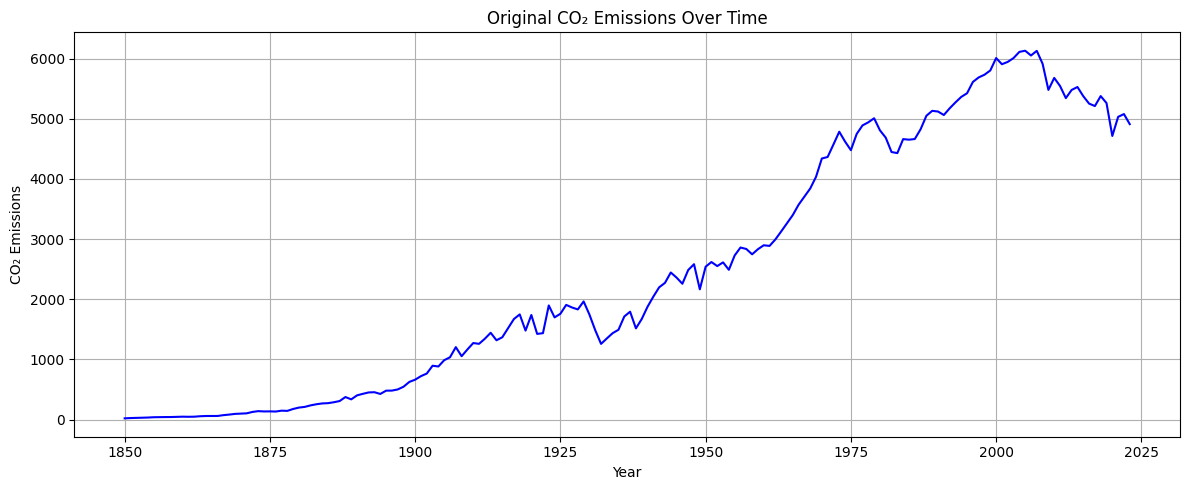

X_train shape: (145, 15, 9), y_train shape: (145,)
X_test shape: (14, 15, 9), y_test shape: (14,)
Training on first 160 years, testing on last 14 years
Using device: cuda
Training on 145 samples
Testing on 14 samples (last 14 years)
Epoch   1 | Train Loss: 57.5516
Epoch  10 | Train Loss: 52.9946
Epoch  20 | Train Loss: 35.5803
Epoch  30 | Train Loss: 18.7656
Epoch  40 | Train Loss: 6.8676
Epoch  50 | Train Loss: 1.9007
Epoch  60 | Train Loss: 2.0598
Epoch  70 | Train Loss: 1.7974
Epoch  80 | Train Loss: 1.8485
Epoch  90 | Train Loss: 1.8675
Epoch 100 | Train Loss: 1.7139
Epoch 110 | Train Loss: 1.7334
Epoch 120 | Train Loss: 1.6111
Epoch 130 | Train Loss: 1.1254
Epoch 140 | Train Loss: 0.3077
Epoch 150 | Train Loss: 0.3170
Epoch 160 | Train Loss: 0.4340
Epoch 170 | Train Loss: 0.2929
Epoch 180 | Train Loss: 0.3211
Epoch 190 | Train Loss: 0.2651
Epoch 200 | Train Loss: 0.2889
Epoch 210 | Train Loss: 0.2818
Epoch 220 | Train Loss: 0.3288
Epoch 230 | Train Loss: 0.2758
Epoch 240 | Train L

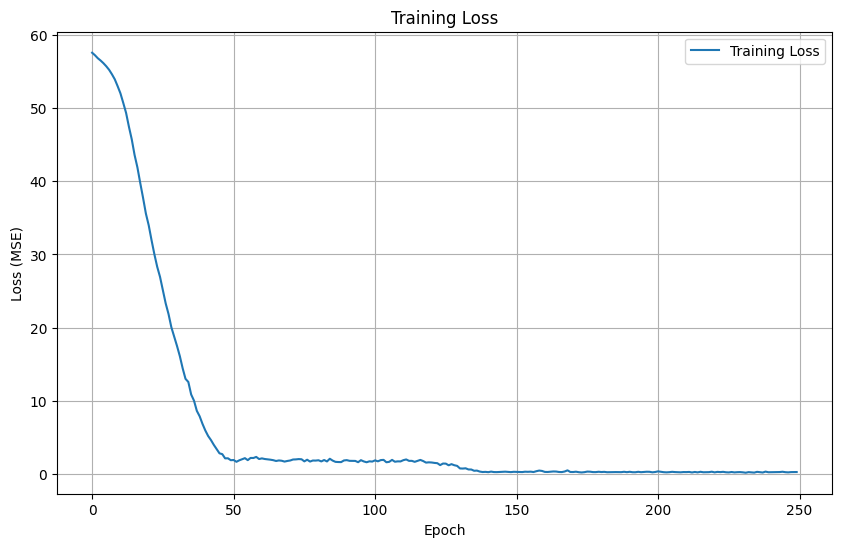


--- Test Set Evaluation ---
Log Scale - MSE: 0.0016, MAE: 0.0348, R²: 0.3344
Original Scale - MSE: 44259.17, MAE: 182.27, R²: 0.3246


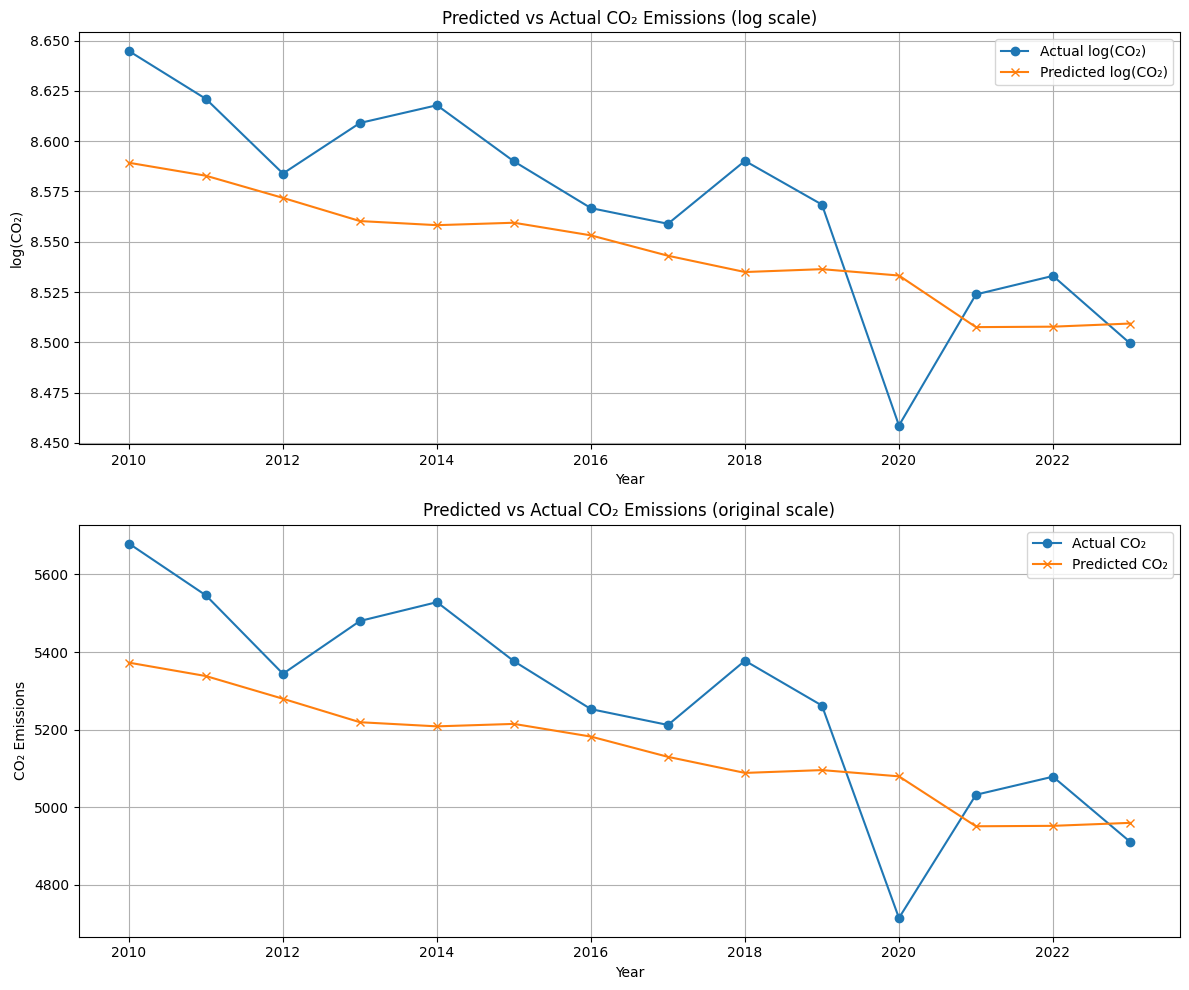

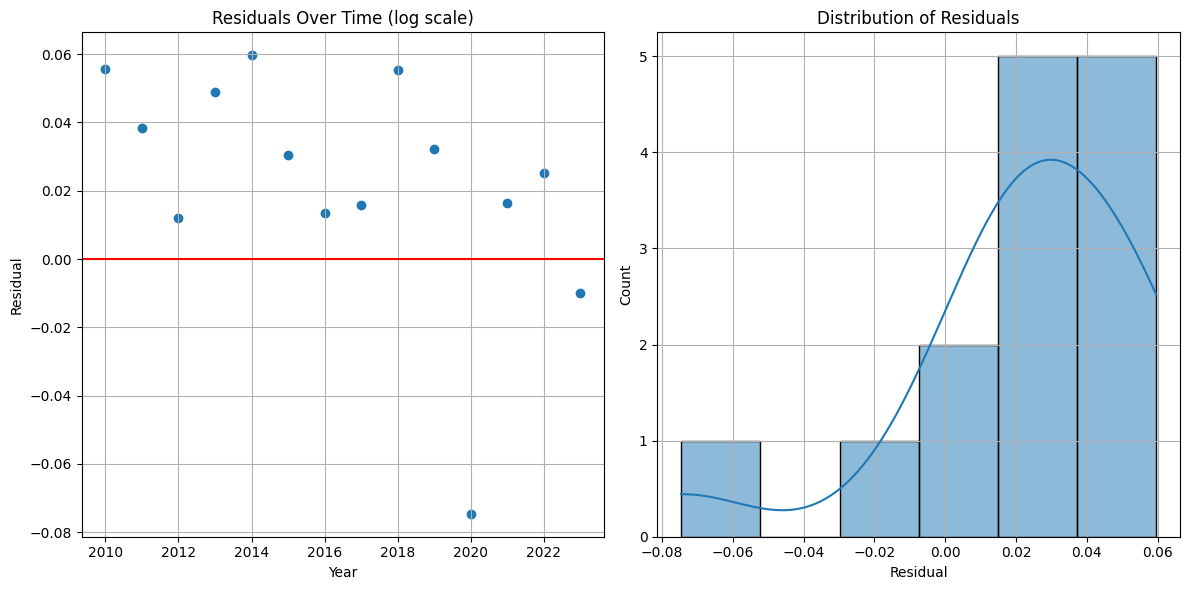

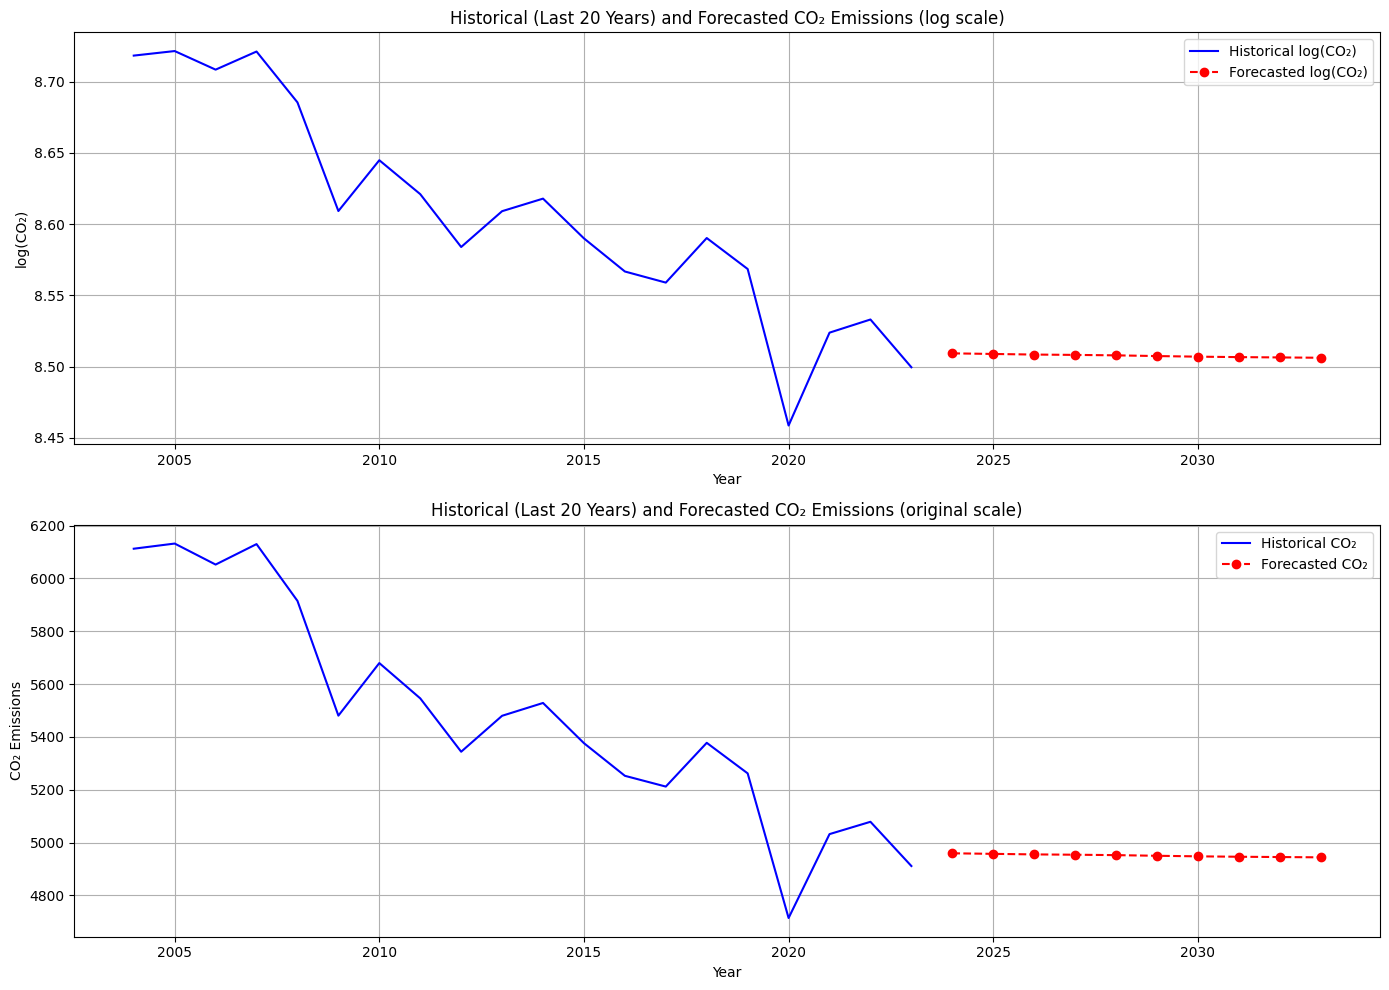


--- CO₂ Emission Forecast ---
   Year  Forecasted_log_CO2  Forecasted_CO2
0  2024            8.509283     4959.605385
1  2025            8.508854     4957.476981
2  2026            8.508430     4955.377851
3  2027            8.508192     4954.196299
4  2028            8.507876     4952.632358
5  2029            8.507381     4950.181130
6  2030            8.506957     4948.080368
7  2031            8.506639     4946.508921
8  2032            8.506416     4945.404959
9  2033            8.506191     4944.291811

Model saved to 'co2_lstm_model.pth'


In [8]:
torch.cuda.empty_cache()
file_path = r"C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\data\processed_data\United_States.csv"  # Update with your actual path
df = pd.read_csv(file_path)

# --- Plot CO2 ---
plt.figure(figsize=(12, 5))
plt.plot(df['year'], df['co2'], label='Original CO₂', color='blue')
plt.title("Original CO₂ Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions")
plt.grid(True)
plt.tight_layout()
plt.show()

# Preprocess data
data = preprocess_data(df)
    
# Create sequences
sequence_length = 15
X, y = create_sequences(data, sequence_length)

# Get input size (number of features)
input_size = X.shape[2]

# Train and evaluate the model
test_years = 15  # Last 15 years for testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, test_preds, test_actuals,test_years_values = train_and_evaluate(X, y,df, input_size,sequence_length)

# Evaluate and visualize results
log_mse, log_mae, log_r2, co2_mse, co2_mae, co2_r2 = evaluate_and_visualize(
    model, test_preds, test_actuals,  test_years_values)

# Forecast future values
forecasted_log, forecasted_co2, future_years = forecast_future(
    model, X, df, forecast_years=10, device=device)

# Print forecast results in a table
forecast_df = pd.DataFrame({
    'Year': future_years,
    'Forecasted_log_CO2': forecasted_log,
    'Forecasted_CO2': forecasted_co2
})
print("\n--- CO₂ Emission Forecast ---")
print(forecast_df)

# Save the model
torch.save(model.state_dict(), r'C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\models\co2_lstm_model.pth')
print("\nModel saved to 'co2_lstm_model.pth'")